In [1]:
import requests
import sqlite3
import pandas as pd
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
url = "https://air-quality-api.open-meteo.com/v1/air-quality"
params = {
	"latitude": 41.2647,
	"longitude": 69.2163,
	"hourly": ["pm10", "pm2_5"],
	"past_days": 7,
	"forecast_days": 7,
}

In [3]:
# loading data from api
response = requests.get(url, params=params)
data = response.json()

# checking keys
for key in data.keys():
    print(key)

latitude
longitude
generationtime_ms
utc_offset_seconds
timezone
timezone_abbreviation
elevation
hourly_units
hourly


In [4]:
# loading hourly column that contains aqi info to the data frame
df = pd.DataFrame(data['hourly'])
df.describe()

,pm10,pm2_5
count,289.000000,289.000000
mean,45.668858,42.601384
std,20.582613,18.953312
min,16.300000,14.100000
25%,28.300000,27.200000
50%,41.800000,39.000000
75%,58.800000,55.300000
max,99.700000,93.800000


In [5]:
# check how many missing values
df.isna().sum()

time      0
pm10     47
pm2_5    47
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
# formatting time column
df["time"] = df["time"].str.replace("T", " ")
df["time"] = pd.to_datetime(df["time"])   
df = df.set_index("time")            

In [8]:
# both pm10 and pm2_5 have strong relationship
corr = df[['pm10','pm2_5']].corr()
corr

,pm10,pm2_5
pm10,1.000000,0.990476
pm2_5,0.990476,1.000000


<Axes: >

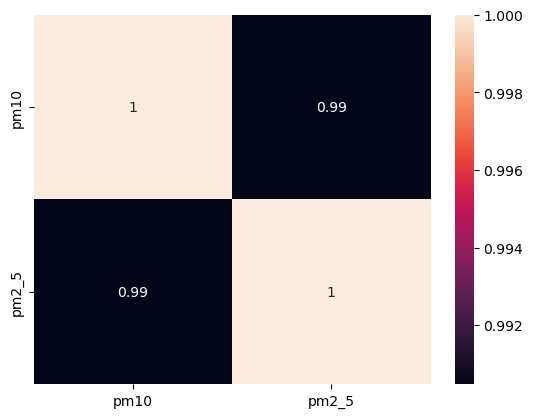

In [9]:
sns.heatmap(corr, annot=True)

In [10]:
# check flags for high levels of air pollution (above 50 µg/m³ units)
df['pm10_high'] = df['pm10'] > 50
df['pm2_5_high'] = df['pm2_5'] > 50

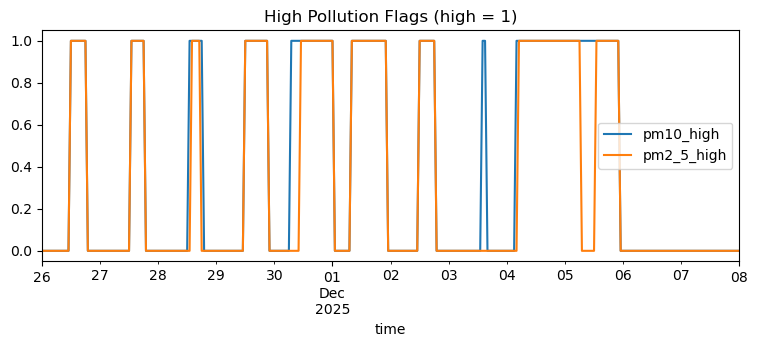

In [11]:
# based on the plot we can see almost everyday the levels of air pollution were high from 11/26/25 to 12/03/25
df[['pm10_high', 'pm2_5_high']].astype(int).plot(figsize=(9,3))
plt.title("High Pollution Flags (high = 1)")
plt.show()

In [12]:
# extraact hour index from time to see how pollution levels were changing by hours 
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')[['pm10', 'pm2_5']].mean()

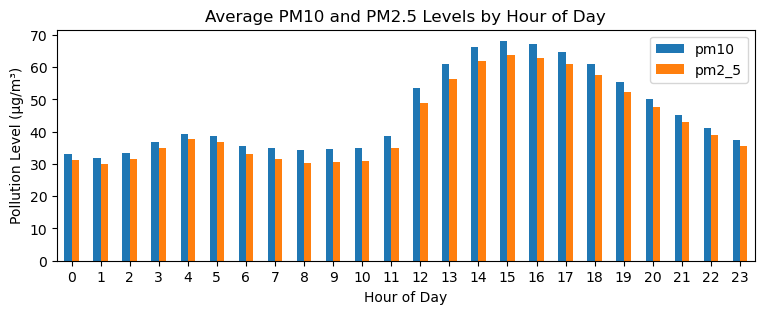

In [13]:
# Based on this bar chart we can conclude that on average pollution levels start to 
# increase after 12 pm and peak at 3pm and after levels start slowly to decrease
hourly_avg.plot(kind='bar', figsize=(9,3))
plt.title('Average PM10 and PM2.5 Levels by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Pollution Level (µg/m³)')
plt.xticks(rotation=0)
plt.show()

In [14]:
# adding two additional columns to our dataframe
df["latitude"] = data["latitude"]
df["longitude"] = data["longitude"]
df

,pm10,pm2_5,pm10_high,pm2_5_high,hour,latitude,longitude
time,,,,,,,
2025-11-26 00:00:00,18.5,17.7,False,False,0,41.300003,69.2
2025-11-26 01:00:00,18.9,18.0,False,False,1,41.300003,69.2
2025-11-26 02:00:00,22.8,21.8,False,False,2,41.300003,69.2
2025-11-26 03:00:00,28.9,27.9,False,False,3,41.300003,69.2
2025-11-26 04:00:00,34.5,33.6,False,False,4,41.300003,69.2
...,...,...,...,...,...,...,...
2025-12-07 20:00:00,22.6,19.3,False,False,20,41.300003,69.2
2025-12-07 21:00:00,20.9,18.0,False,False,21,41.300003,69.2
2025-12-07 22:00:00,19.4,16.6,False,False,22,41.300003,69.2


In [18]:
# loading our data frame to sqlite database
def load_to_sqlite(df, db_path="db/aqi_levels.db"):
    os.makedirs("db", exist_ok=True)
    connection = sqlite3.connect(db_path)
    df.to_sql("aqi_levels_Tashkent", connection, if_exists="append", index=False)
    connection.close()

In [20]:
load_to_sqlite(df)